In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN, SpectralClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn_extra.cluster import KMedoids
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load the diabetes dataset
df = pd.read_csv('datasets/diabetes.csv')

print("Dataset Shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())

# Prepare data for clustering
# Remove the target column (Outcome) since clustering is unsupervised
X = df.drop('Outcome', axis=1)
y_true = df['Outcome']  # Keep for comparison

# Standardize the features (important for distance-based algorithms)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"\nNumber of samples: {X.shape[0]}")
print(f"Number of features: {X.shape[1]}")

Dataset Shape: (768, 9)

First 5 rows:
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  

Number of samples: 768
Number of features: 8


1. K-MEANS CLUSTERING


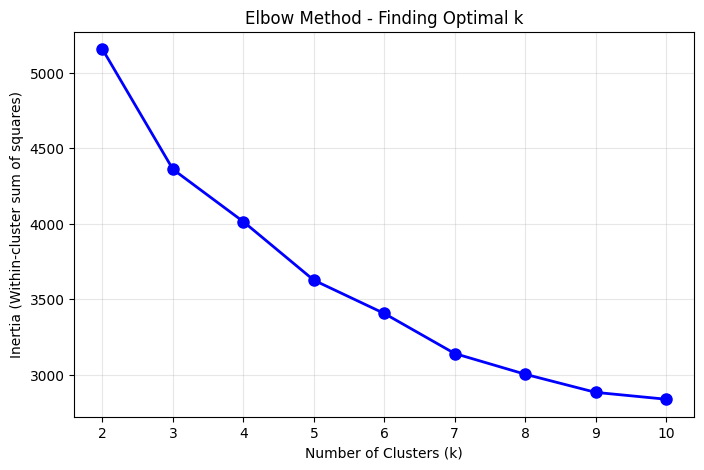


Using k = 3 clusters

K-Means Results:
Silhouette Score: 0.1807
Cluster sizes: [213 221 334]


In [3]:
# 1. K-MEANS CLUSTERING
print("=" * 50)
print("1. K-MEANS CLUSTERING")
print("=" * 50)

# Find optimal number of clusters using Elbow Method
inertias = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertias, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Within-cluster sum of squares)')
plt.title('Elbow Method - Finding Optimal k')
plt.grid(True, alpha=0.3)
plt.show()

# Use k=3 based on elbow method
optimal_k = 3
print(f"\nUsing k = {optimal_k} clusters")

# Apply K-Means
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_labels = kmeans.fit_predict(X_scaled)

# Evaluate
kmeans_silhouette = silhouette_score(X_scaled, kmeans_labels)

print(f"\nK-Means Results:")
print(f"Silhouette Score: {kmeans_silhouette:.4f}")
print(f"Cluster sizes: {np.bincount(kmeans_labels)}")

In [4]:
# 2. K-MEDOIDS CLUSTERING
print("=" * 50)
print("2. K-MEDOIDS CLUSTERING")
print("=" * 50)

# Apply K-Medoids (similar to K-Means but uses medoids instead of centroids)
kmedoids = KMedoids(n_clusters=optimal_k, random_state=42, method='pam')
kmedoids_labels = kmedoids.fit_predict(X_scaled)

# Evaluate
kmedoids_silhouette = silhouette_score(X_scaled, kmedoids_labels)

print(f"\nK-Medoids Results:")
print(f"Silhouette Score: {kmedoids_silhouette:.4f}")
print(f"Cluster sizes: {np.bincount(kmedoids_labels)}")
print(f"\nMedoid indices (cluster centers): {kmedoids.medoid_indices_}")

2. K-MEDOIDS CLUSTERING

K-Medoids Results:
Silhouette Score: 0.1366
Cluster sizes: [298 167 303]

Medoid indices (cluster centers): [122 603 444]

K-Medoids Results:
Silhouette Score: 0.1366
Cluster sizes: [298 167 303]

Medoid indices (cluster centers): [122 603 444]


In [5]:
# 3. DBSCAN CLUSTERING
print("=" * 50)
print("3. DBSCAN CLUSTERING")
print("=" * 50)

# DBSCAN finds clusters based on density
# eps = maximum distance between two points to be in same neighborhood
# min_samples = minimum points needed to form a dense region

# Try different eps values to find a good one
eps_values = [0.5, 0.7, 0.9, 1.1, 1.3]

print("Testing different eps values:")
for eps in eps_values:
    dbscan_test = DBSCAN(eps=eps, min_samples=5)
    labels_test = dbscan_test.fit_predict(X_scaled)
    n_clusters = len(set(labels_test)) - (1 if -1 in labels_test else 0)
    n_noise = list(labels_test).count(-1)
    print(f"eps={eps}: {n_clusters} clusters, {n_noise} noise points")

# Use eps=0.9 as it gives good balance
dbscan = DBSCAN(eps=0.9, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_scaled)

# Count clusters and noise
n_clusters_dbscan = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise = list(dbscan_labels).count(-1)

print(f"\nDBSCAN Results (eps=0.9, min_samples=5):")
print(f"Number of clusters: {n_clusters_dbscan}")
print(f"Number of noise points: {n_noise}")

# Calculate silhouette only if we have more than 1 cluster
if n_clusters_dbscan > 1:
    # Remove noise points for silhouette calculation
    mask = dbscan_labels != -1
    dbscan_silhouette = silhouette_score(X_scaled[mask], dbscan_labels[mask])
    print(f"Silhouette Score: {dbscan_silhouette:.4f}")
else:
    dbscan_silhouette = -1
    print("Not enough clusters for silhouette score")

3. DBSCAN CLUSTERING
Testing different eps values:
eps=0.5: 0 clusters, 768 noise points
eps=0.7: 2 clusters, 758 noise points
eps=0.9: 7 clusters, 586 noise points
eps=1.1: 1 clusters, 416 noise points
eps=1.3: 5 clusters, 252 noise points

DBSCAN Results (eps=0.9, min_samples=5):
Number of clusters: 7
Number of noise points: 586
Silhouette Score: 0.0774
Silhouette Score: 0.0774


In [6]:
# 4. SPECTRAL CLUSTERING
print("=" * 50)
print("4. SPECTRAL CLUSTERING")
print("=" * 50)

# Spectral clustering uses graph theory to find clusters
# Good for non-linear cluster shapes

# Apply Spectral Clustering with RBF affinity
spectral = SpectralClustering(n_clusters=optimal_k, affinity='rbf', random_state=42)
spectral_labels = spectral.fit_predict(X_scaled)

# Evaluate
spectral_silhouette = silhouette_score(X_scaled, spectral_labels)

print(f"\nSpectral Clustering Results:")
print(f"Silhouette Score: {spectral_silhouette:.4f}")
print(f"Cluster sizes: {np.bincount(spectral_labels)}")

4. SPECTRAL CLUSTERING

Spectral Clustering Results:
Silhouette Score: 0.3065
Cluster sizes: [733  28   7]

Spectral Clustering Results:
Silhouette Score: 0.3065
Cluster sizes: [733  28   7]


In [7]:
# 5. COMPARISON OF ALL CLUSTERING METHODS
print("=" * 50)
print("5. COMPARISON TABLE")
print("=" * 50)

# Create comparison table
comparison_df = pd.DataFrame({
    'Algorithm': ['K-Means', 'K-Medoids', 'DBSCAN', 'Spectral'],
    'Silhouette Score': [
        kmeans_silhouette, 
        kmedoids_silhouette, 
        dbscan_silhouette, 
        spectral_silhouette
    ],
    'Number of Clusters': [
        optimal_k, 
        optimal_k, 
        n_clusters_dbscan, 
        optimal_k
    ]
})

print("\nClustering Algorithm Comparison:")
print(comparison_df.to_string(index=False))

# Find best algorithm
best_algo = comparison_df.loc[comparison_df['Silhouette Score'].idxmax(), 'Algorithm']
best_score = comparison_df['Silhouette Score'].max()
print(f"\nBest Algorithm: {best_algo} (Silhouette Score: {best_score:.4f})")

5. COMPARISON TABLE

Clustering Algorithm Comparison:
Algorithm  Silhouette Score  Number of Clusters
  K-Means          0.180694                   3
K-Medoids          0.136633                   3
   DBSCAN          0.077419                   7
 Spectral          0.306491                   3

Best Algorithm: Spectral (Silhouette Score: 0.3065)


6. VISUALIZATIONS


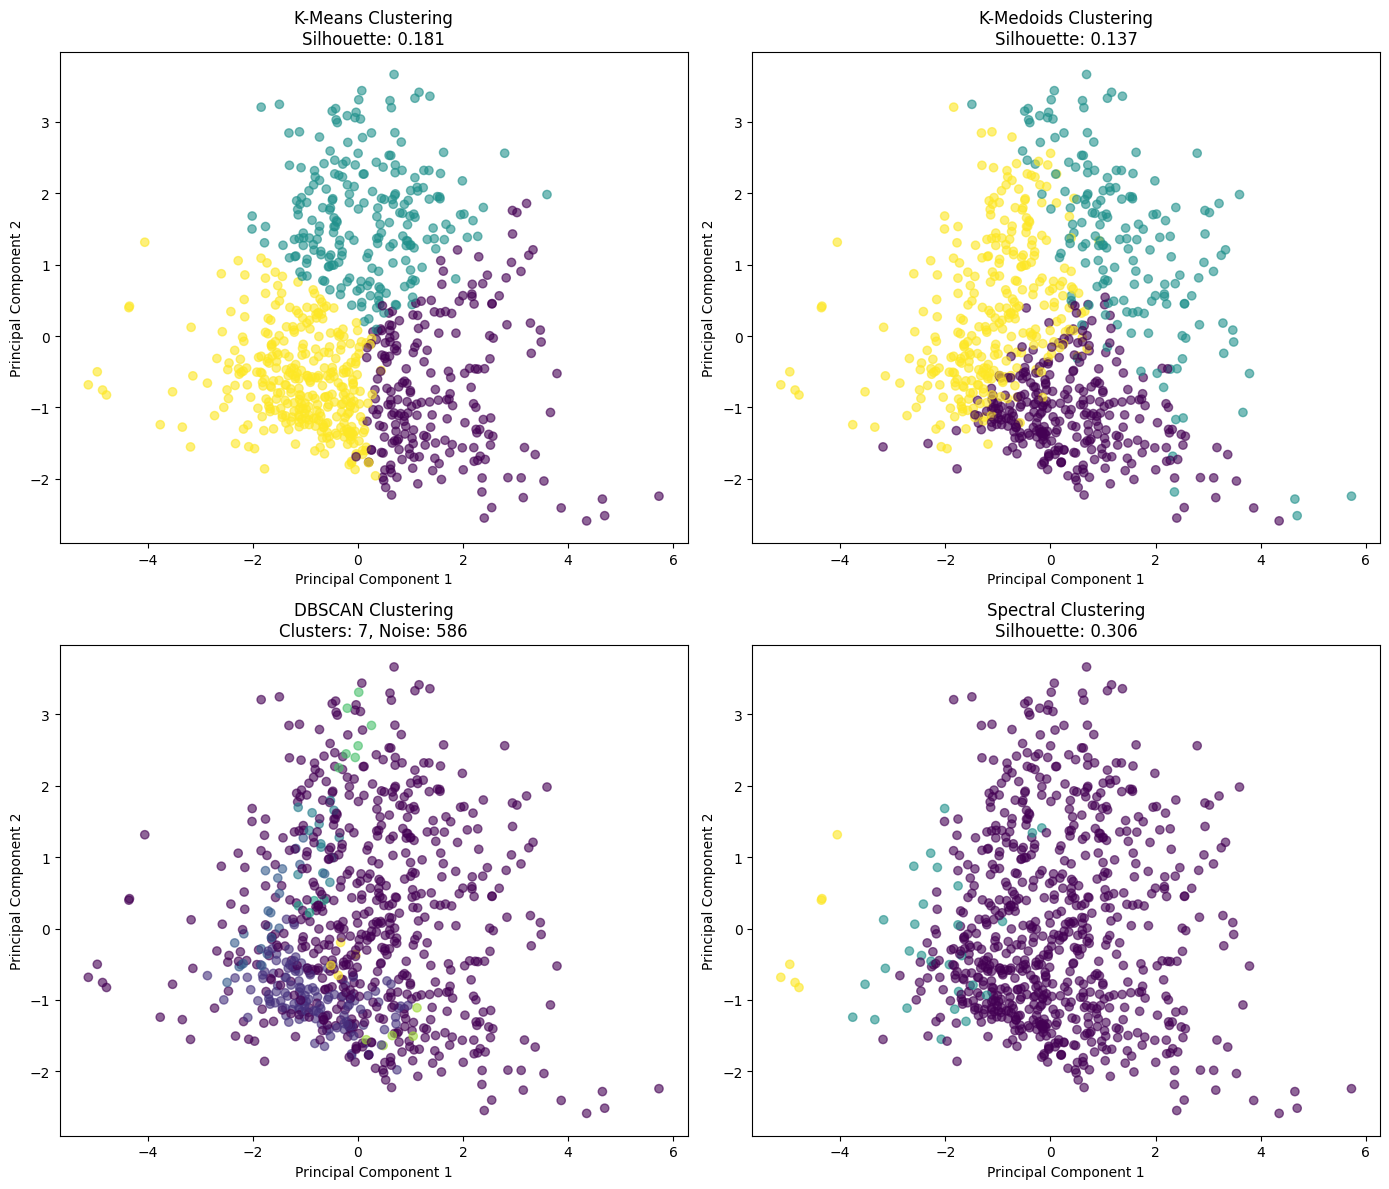

Visualization complete!


In [8]:
# 6. VISUALIZE ALL CLUSTERING RESULTS
print("=" * 50)
print("6. VISUALIZATIONS")
print("=" * 50)

# We'll use PCA to reduce dimensions to 2D for visualization
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Create subplots for all methods
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# 1. K-Means
axes[0, 0].scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.6)
axes[0, 0].set_title(f'K-Means Clustering\nSilhouette: {kmeans_silhouette:.3f}')
axes[0, 0].set_xlabel('Principal Component 1')
axes[0, 0].set_ylabel('Principal Component 2')

# 2. K-Medoids
axes[0, 1].scatter(X_pca[:, 0], X_pca[:, 1], c=kmedoids_labels, cmap='viridis', alpha=0.6)
axes[0, 1].set_title(f'K-Medoids Clustering\nSilhouette: {kmedoids_silhouette:.3f}')
axes[0, 1].set_xlabel('Principal Component 1')
axes[0, 1].set_ylabel('Principal Component 2')

# 3. DBSCAN
axes[1, 0].scatter(X_pca[:, 0], X_pca[:, 1], c=dbscan_labels, cmap='viridis', alpha=0.6)
axes[1, 0].set_title(f'DBSCAN Clustering\nClusters: {n_clusters_dbscan}, Noise: {n_noise}')
axes[1, 0].set_xlabel('Principal Component 1')
axes[1, 0].set_ylabel('Principal Component 2')

# 4. Spectral
axes[1, 1].scatter(X_pca[:, 0], X_pca[:, 1], c=spectral_labels, cmap='viridis', alpha=0.6)
axes[1, 1].set_title(f'Spectral Clustering\nSilhouette: {spectral_silhouette:.3f}')
axes[1, 1].set_xlabel('Principal Component 1')
axes[1, 1].set_ylabel('Principal Component 2')

plt.tight_layout()
plt.show()

print("Visualization complete!")

7. PERFORMANCE COMPARISON


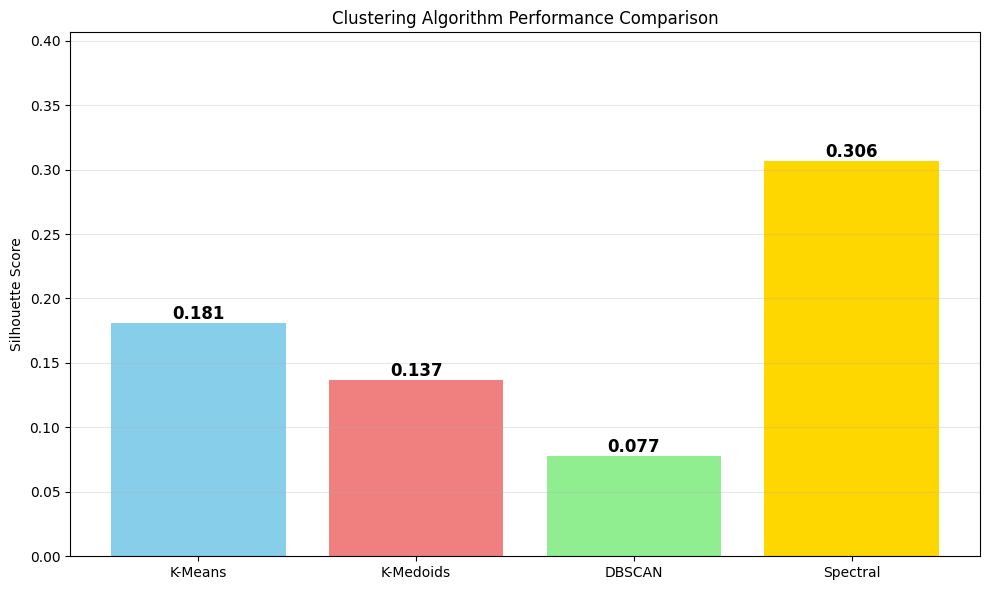


Summary:
• K-Means: Fast and simple, works well with spherical clusters
• K-Medoids: More robust to outliers than K-Means
• DBSCAN: Can find clusters of any shape and identifies outliers
• Spectral: Good for complex, non-linear cluster boundaries


In [9]:
# 7. PERFORMANCE COMPARISON CHART
print("=" * 50)
print("7. PERFORMANCE COMPARISON")
print("=" * 50)

# Bar chart comparing silhouette scores
algorithms = ['K-Means', 'K-Medoids', 'DBSCAN', 'Spectral']
scores = [kmeans_silhouette, kmedoids_silhouette, dbscan_silhouette, spectral_silhouette]

plt.figure(figsize=(10, 6))
bars = plt.bar(algorithms, scores, color=['skyblue', 'lightcoral', 'lightgreen', 'gold'])
plt.ylabel('Silhouette Score')
plt.title('Clustering Algorithm Performance Comparison')
plt.ylim(0, max(scores) + 0.1)

# Add value labels on bars
for bar, score in zip(bars, scores):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{score:.3f}',
             ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print("\nSummary:")
print("• K-Means: Fast and simple, works well with spherical clusters")
print("• K-Medoids: More robust to outliers than K-Means")
print("• DBSCAN: Can find clusters of any shape and identifies outliers")
print("• Spectral: Good for complex, non-linear cluster boundaries")